In [ ]:
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import random
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

In [24]:
main_path = "/content/drive/MyDrive/Adv. Deep Learning Project"
os.chdir(main_path)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Adv. Deep Learning Project


In [25]:
class DeWeatherDataset(Dataset):
    def __init__(self, input_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.transform = transform

        self.input_images = sorted(os.listdir(self.input_dir))
        self.gt_images = sorted(os.listdir(self.gt_dir))

        assert len(self.input_images) == len(self.gt_images), "Input and GT count mismatch!"

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_images[idx])

        input_img = Image.open(input_path).convert('RGB')
        gt_img = Image.open(gt_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            gt_img = self.transform(gt_img)

        return input_img, gt_img


def get_dataloaders(batch_size=16, img_size=256, train_limit=2000, test_limit=1000):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    rain_train_dataset = DeWeatherDataset(main_path + '/Data/rain/train/rainy', main_path + '/Data/rain/train/GT', transform=transform)
    rain_test_dataset = DeWeatherDataset(main_path + '/Data/rain/test/rainy', main_path + '/Data/rain/test/GT', transform=transform)

    haze_train_dataset = DeWeatherDataset(main_path + '/Data/haze/train/hazy', main_path + '/Data/haze/train/GT', transform=transform)
    haze_test_dataset = DeWeatherDataset(main_path + '/Data/haze/test/hazy', main_path + '/Data/haze/test/GT', transform=transform)

    def get_subset(dataset, limit):
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        return Subset(dataset, indices[:limit])

    rain_train_dataset = get_subset(rain_train_dataset, train_limit // 2)
    haze_train_dataset = get_subset(haze_train_dataset, train_limit // 2)

    rain_test_dataset = get_subset(rain_test_dataset, test_limit // 2)
    haze_test_dataset = get_subset(haze_test_dataset, test_limit // 2)

    rain_train_loader = DataLoader(rain_train_dataset, batch_size=batch_size, shuffle=True)
    rain_test_loader = DataLoader(rain_test_dataset, batch_size=batch_size, shuffle=False)
    haze_train_loader = DataLoader(haze_train_dataset, batch_size=batch_size, shuffle=True)
    haze_test_loader = DataLoader(haze_test_dataset, batch_size=batch_size, shuffle=False)

    combined_train_dataset = ConcatDataset([rain_train_dataset, haze_train_dataset])
    combined_test_dataset = ConcatDataset([rain_test_dataset, haze_test_dataset])

    combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
    combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'rain_train_loader': rain_train_loader,
        'rain_test_loader': rain_test_loader,
        'haze_train_loader': haze_train_loader,
        'haze_test_loader': haze_test_loader,
        'combined_train_loader': combined_train_loader,
        'combined_test_loader': combined_test_loader,
    }

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
###########################
# 1. Triplet Attention Block
###########################
class TripletAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(TripletAttentionBlock, self).__init__()

        # Local Pixel-wise Attention (LPA)
        self.lpa = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Global Strip-wise Attention (GSA)
        self.gsa_h = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 3), padding=(0, 1))
        self.gsa_v = nn.Conv2d(in_channels, in_channels, kernel_size=(3, 1), padding=(1, 0))

        # Global Distribution Attention (GDA)
        self.gda_conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.gda_in = nn.InstanceNorm2d(in_channels // 2)
        self.gda_conv2 = nn.Conv2d(in_channels // 2 * 2, in_channels, kernel_size=1)

    def forward(self, x):
        # LPA
        lpa_map = self.lpa(x)

        # GSA
        gsa_h = self.gsa_h(x)
        gsa_v = self.gsa_v(x)
        gsa_map = torch.sigmoid(gsa_h + gsa_v)

        # Combine LPA and GSA
        spatial_attended = x * lpa_map * gsa_map

        # GDA
        gda1 = self.gda_in(self.gda_conv1(x))
        gda2 = self.gda_conv1(x)
        gda_cat = torch.cat([gda1, gda2], dim=1)
        gda_out = self.gda_conv2(gda_cat)

        return spatial_attended + gda_out + x

In [28]:
###########################
# 2. TANet Architecture
###########################
class TANet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(TANet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            TripletAttentionBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            TripletAttentionBlock(128),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            TripletAttentionBlock(64),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
###########################
# 3. Loss Functions
###########################
def charbonnier_loss(pred, gt, eps=1e-3):
    return torch.mean(torch.sqrt((pred - gt) ** 2 + eps ** 2))

def fft_loss(pred, gt):
    pred_fft = torch.fft.fft2(pred, norm='ortho')
    gt_fft = torch.fft.fft2(gt, norm='ortho')
    return torch.mean(torch.abs(pred_fft - gt_fft))

def total_loss(pred, gt, lambda_fft=1e-2):
    return charbonnier_loss(pred, gt) + lambda_fft * fft_loss(pred, gt)

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))

In [34]:
###########################
# 4. Train + Eval Loop
###########################
def train(model, dataloader, optimizer, save_dir, num_epochs=5):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        i=1
        for inputs, targets in dataloader:
            if i%75==0: print(f"Processing batch {i}/{len(dataloader)}")
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = total_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            i+=1

        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        torch.save(model.state_dict(), save_dir + '/model.pth')

    print(f"Model saved to {save_dir}")

    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('TANet Training Loss Curve')
    plt.grid(True)
    plt.savefig(save_dir + '/training_loss_curve.png')
    print("Saved training loss curve to 'training_loss_curve.png'")


def evaluate_and_visualize(model, dataloader, save_dir, img_type=""):
    model.eval()
    all_psnr = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            for i in range(outputs.size(0)):
                score = psnr(outputs[i], targets[i])
                all_psnr.append(score.item())

        inputs, targets = next(iter(dataloader))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        for i in range(min(8, inputs.size(0))):
            comparison = torch.cat([inputs[i], outputs[i], targets[i]], dim=2)
            img_path = f"{save_dir}/{img_type}_sample_{i}.png"
            vutils.save_image(comparison, img_path, normalize=True)
            # Display image
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6, 2))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{img_type.title()} Sample {i}")
            plt.show()

        print(f"Saved sample comparison images to `{save_dir}`.")

    avg_psnr = np.mean(all_psnr)
    print(f"Average PSNR on test set {img_type}: {avg_psnr:.2f} dB")

    plt.figure()
    plt.hist(all_psnr, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'PSNR Distribution on Test Set {img_type.title()}')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(save_dir + f'/{img_type}_psnr_distribution.png')
    print(f"Saved PSNR histogram to '{save_dir}/{img_type}_psnr_distribution.png'")

In [35]:
loaders = get_dataloaders(batch_size=8, img_size=256, train_limit=6000, test_limit=2000)
train_loader = loaders['combined_train_loader']
test_loader = loaders['combined_test_loader']
rain_test_loader = loaders['rain_test_loader']
haze_test_loader = loaders['haze_test_loader']

In [36]:
model = TANet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model_dir = main_path + '/tanet'
os.makedirs(model_dir, exist_ok=True)

In [37]:
train(model, train_loader, optimizer, model_dir, num_epochs=50)

Processing batch 75/750
Processing batch 150/750
Processing batch 225/750
Processing batch 300/750
Processing batch 375/750
Processing batch 450/750
Processing batch 525/750
Processing batch 600/750
Processing batch 675/750
Processing batch 750/750

Epoch [1/50], Loss: 0.0918
Processing batch 75/750
Processing batch 150/750
Processing batch 225/750
Processing batch 300/750
Processing batch 375/750
Processing batch 450/750
Processing batch 525/750
Processing batch 600/750
Processing batch 675/750
Processing batch 750/750

Epoch [2/50], Loss: 0.0721
Processing batch 75/750
Processing batch 150/750
Processing batch 225/750
Processing batch 300/750
Processing batch 375/750
Processing batch 450/750
Processing batch 525/750
Processing batch 600/750
Processing batch 675/750
Processing batch 750/750

Epoch [3/50], Loss: 0.0673
Processing batch 75/750
Processing batch 150/750
Processing batch 225/750
Processing batch 300/750
Processing batch 375/750
Processing batch 450/750
Processing batch 525

KeyboardInterrupt: 

Saved training loss curve to '/content/drive/MyDrive/Adv. Deep Learning Project/tanet/training_loss_curve.png'


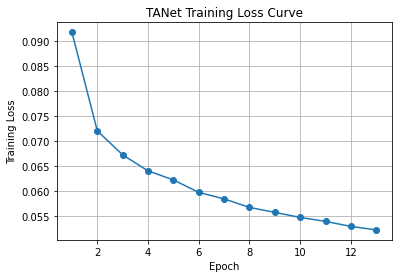

In [ ]:
# follwong train_losses are taken from above output to plot loss curve (since the training was interrupted as we were running out of GPU time)
train_losses = [0.0918, 0.0721, 0.0673, 0.0641, 0.0623, 0.0598, 0.0585, 0.0568, 0.0558, 0.0548, 0.0540, 0.0530, 0.0523]
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('TANet Training Loss Curve')
plt.grid(True)
plt.savefig(model_dir + '/training_loss_curve.png')
print(f"Saved training loss curve to '{model_dir}/training_loss_curve.png'")

Evaluating model and saving outputs...


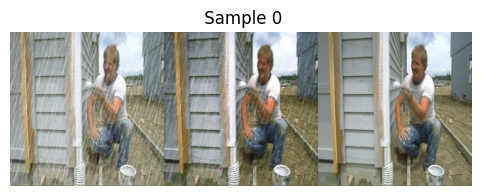

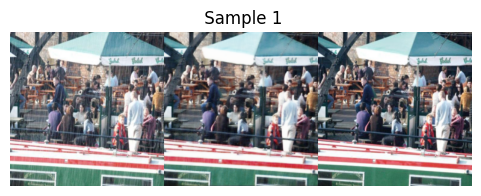

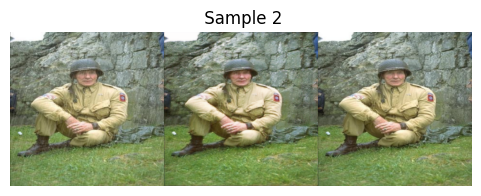

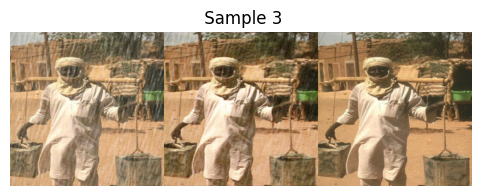

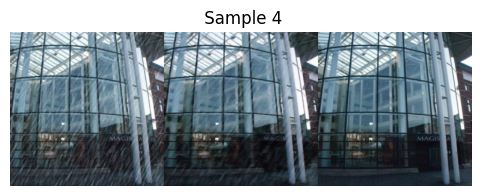

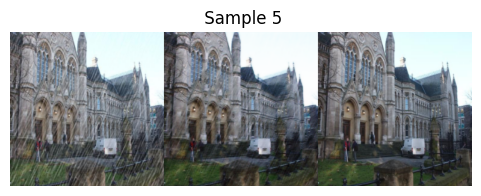

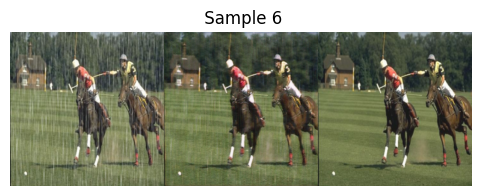

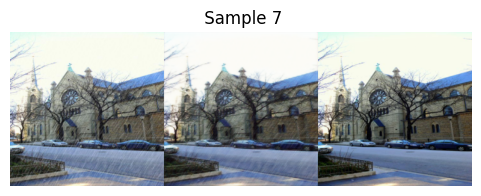

Saved sample comparison images to `/content/drive/MyDrive/Adv. Deep Learning Project/tanet`.
Average PSNR on test set : 24.56 dB
Saved PSNR histogram to '/content/drive/MyDrive/Adv. Deep Learning Project/tanet/_psnr_distribution.png'


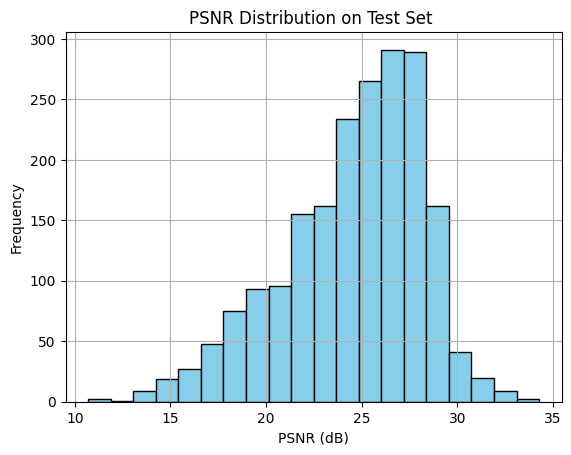

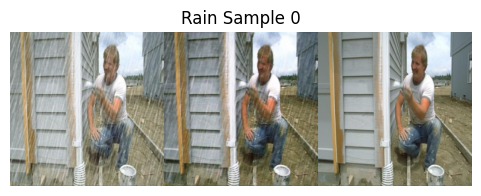

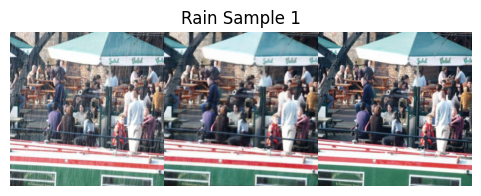

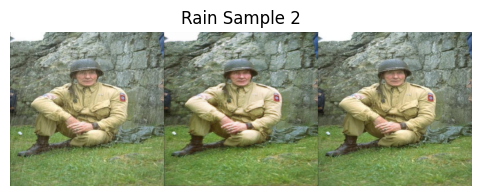

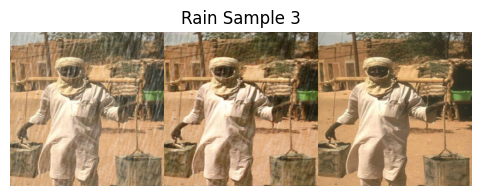

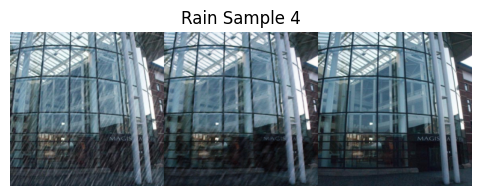

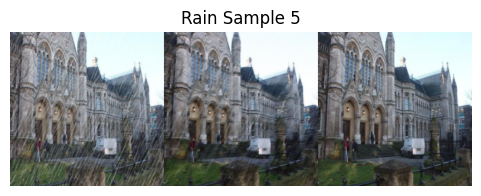

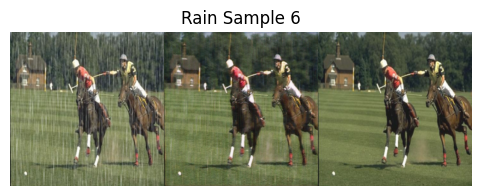

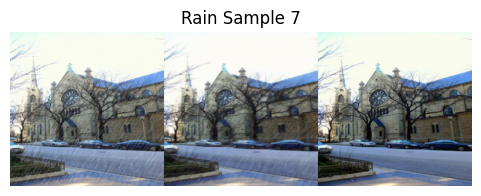

Saved sample comparison images to `/content/drive/MyDrive/Adv. Deep Learning Project/tanet`.
Average PSNR on test set rain: 26.52 dB
Saved PSNR histogram to '/content/drive/MyDrive/Adv. Deep Learning Project/tanet/rain_psnr_distribution.png'


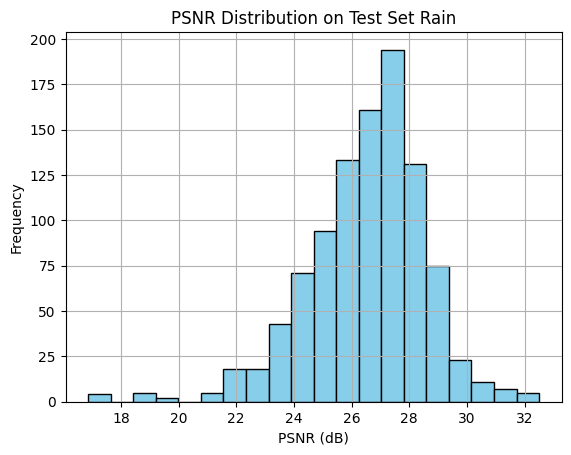

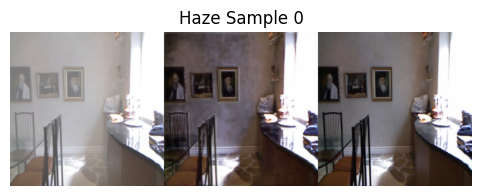

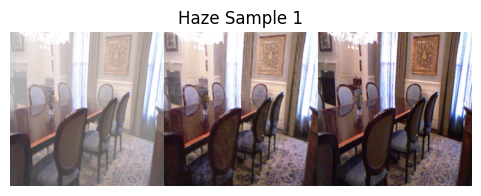

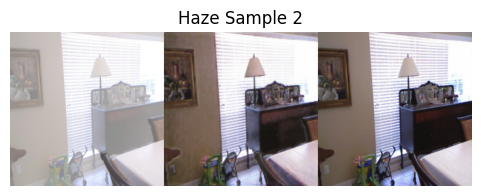

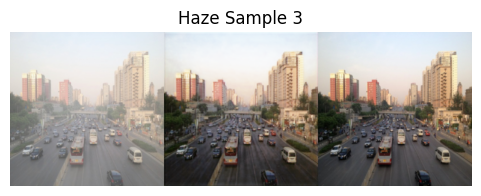

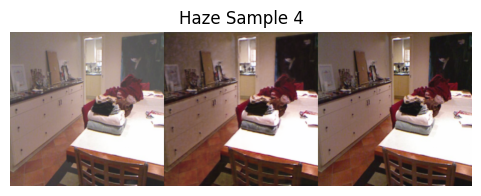

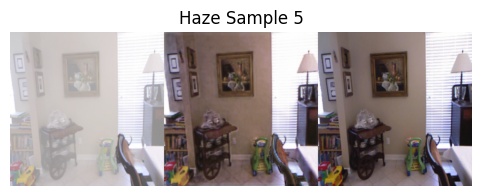

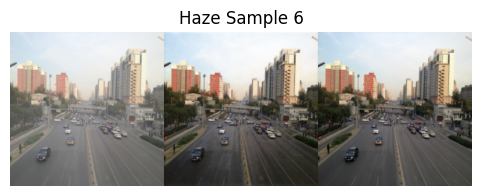

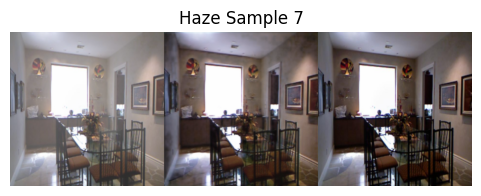

Saved sample comparison images to `/content/drive/MyDrive/Adv. Deep Learning Project/tanet`.
Average PSNR on test set haze: 22.60 dB
Saved PSNR histogram to '/content/drive/MyDrive/Adv. Deep Learning Project/tanet/haze_psnr_distribution.png'


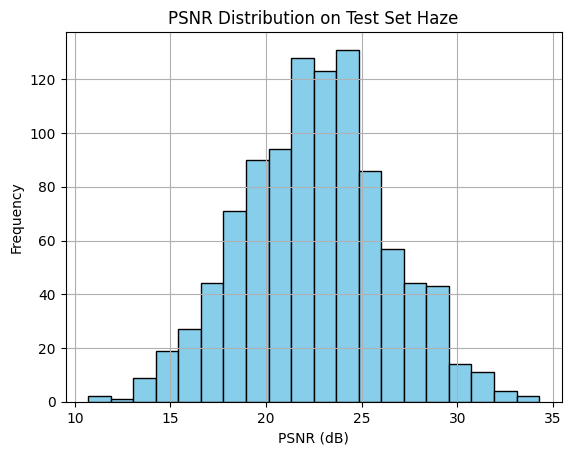

In [38]:
print("Evaluating model and saving outputs...")
evaluate_and_visualize(model, test_loader, model_dir)
evaluate_and_visualize(model, rain_test_loader, model_dir, img_type = "rain")
evaluate_and_visualize(model, haze_test_loader, model_dir, img_type = "haze")